# Working with raster data and points: Exercise solutions

**Author**: Andrea Ballatore (Birkbeck, University of London)

**Abstract**: Learn how to load, process, and save geospatial raster data using Python packages.

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [10]:
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
assert os.environ['CONDA_DEFAULT_ENV'] == 'geoprogv1'
# spatial libraries 
import fiona as fi
import geopandas
import pandas as pd
import pysal as sal
import geoplot
import rasterio
import rasterio.plot
import rasterstats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import urllib.request

# create output folder
if not os.path.exists('tmp'):
    os.makedirs('tmp')

import warnings
warnings.filterwarnings('ignore')
    
print('env ok')

Conda env: geoprogv1
env ok


-----
## Exercises

When you are in doubt about how a package or a function work, use the Python website (https://docs.python.org/3.9/) and **Google** to find relevant documentation. `rasterio` and `geopandas` are the main packages used in these exercises.

Execute the notebook **raster_analysis-content.ipynb** before doing these exercises.

### a.
This [dataset](https://github.com/andrea-ballatore/open-geo-data-education/tree/main/datasets/global_precipitation_1950_2017) contains rasters with global precipitation data from 1950 to 2017 in millimetres. Using for loops, retrieve the precipitation raster every 5 years from 1980 to 2015. 
For each raster, generate a plot reusing the `plot_raster` function (copy the function in this notebook) and print min,mean, and max values.

In [2]:
# As rasterio's visualisation functionality is quite complicated,
# we create a function to visualise a raster more easily.
# Based on https://geoscripting-wur.github.io/PythonRaster
# Note the default values (Blues, 10, 10).
# In terms of complexity, this is a realistic function used in data science, with 
# hacks to make things work because of the package limitations.
def plot_raster(rast, val_matrix, plot_title, value_label, cmap='Blues', width=10, height=10, diverge_zero=False):
    """Plots a rasterio raster with sensible settings and with a legend .
        @ rast: rasterio file (used to read the geocoordinates)
        @ val_matrix: extracted values (used to read the raster values)
        @ plot_title: title of the whole figure
        @ value_label: quantity being displayed
        @ diverge_zero: true if using a divergent cmap to center colour map on zero
    """
    fig, ax = plt.subplots(figsize=(10,10))
    # image_hidden is a hack to show the legend
    if diverge_zero:
        image_hidden = ax.imshow(val_matrix, cmap=cmap, norm=TwoSlopeNorm(0))
    else:
        image_hidden = ax.imshow(val_matrix, cmap=cmap)

    ax.clear()
    # plot raster: rast.transform allows the system to show geocoordinates
    if diverge_zero:
        rast_plot = rasterio.plot.show(val_matrix, cmap=cmap, ax=ax, transform=rast.transform, norm=TwoSlopeNorm(0))
    else: 
        rast_plot = rasterio.plot.show(val_matrix, cmap=cmap, ax=ax, transform=rast.transform)
    # set plot title
    ax.set_title(plot_title, fontsize=14)
    # show legend with label
    # hack to fix height
    im_ratio = val_matrix.shape[0]/val_matrix.shape[1] 
    #plt.colorbar(im,fraction=0.046*im_ratio, pad=0.04)
    cbar = fig.colorbar(image_hidden, ax=ax, fraction=0.046*im_ratio, pad=0.04)
    cbar.ax.set_ylabel(value_label, rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    #ax.set_axis_off() # enable/disable axes
    plt.show()

In [7]:
# download files. Asc stands for Ascii, a simple raster format.
years = range(1980, 2016, 5)
for year in years:
    rast_url = 'https://github.com/andrea-ballatore/open-geo-data-education/blob/main/datasets/global_precipitation_1950_2017/rasters/precip_{}-total.asc?raw=true'.format(year)
    local_file_name = 'data/global_precip_raster-{}.asc'.format(year)
    print(local_file_name)
    urllib.request.urlretrieve(rast_url, local_file_name)
    del rast_url, local_file_name

1980
1985
1990
1995
2000
2005
2010
2015
data/global_precip_raster-1980.asc
data/global_precip_raster-1985.asc
data/global_precip_raster-1990.asc
data/global_precip_raster-1995.asc
data/global_precip_raster-2000.asc
data/global_precip_raster-2005.asc
data/global_precip_raster-2010.asc
data/global_precip_raster-2015.asc


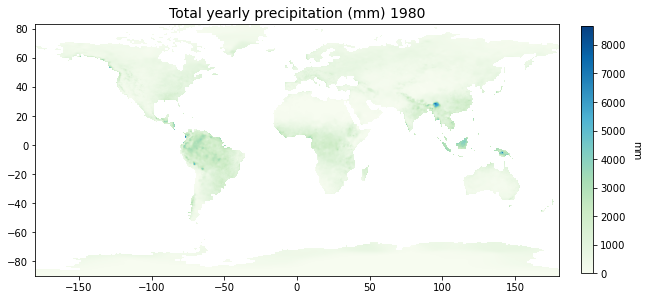

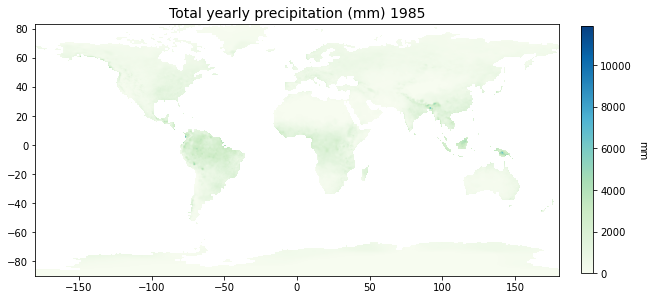

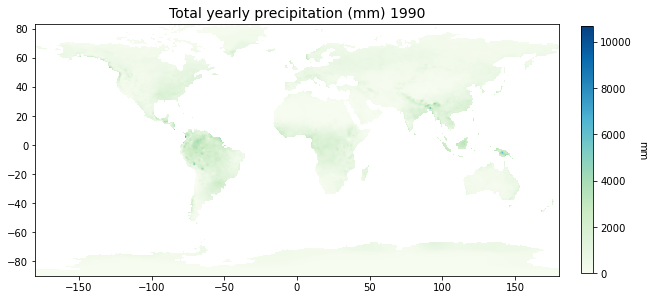

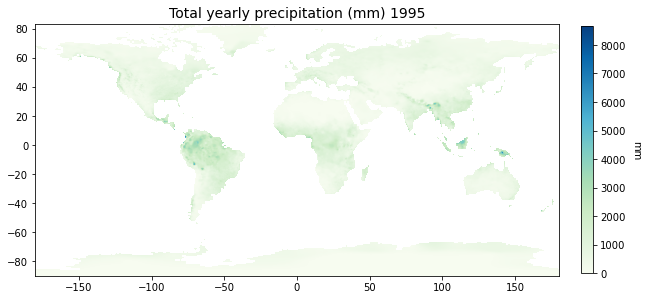

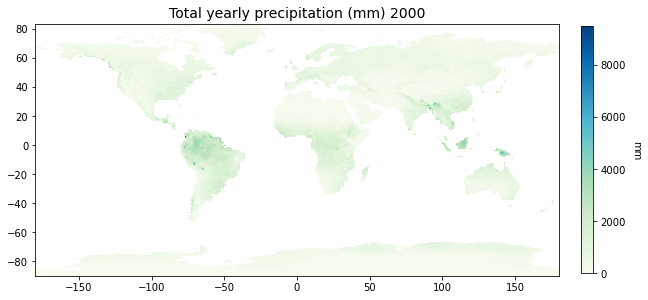

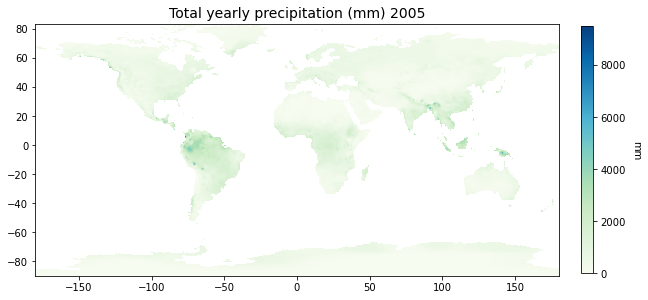

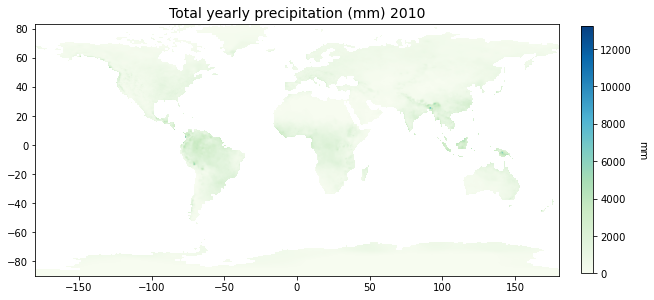

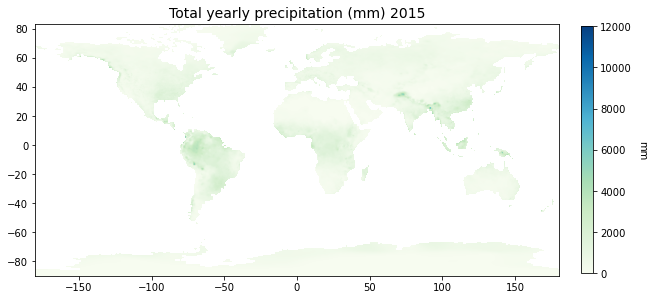

In [4]:
# For simplicity, we are keeping all rasters in a geographic reference system.
# In a scientific study, we would have to project them for visualisation.

# plot precipitation rasters:
for year in years:
    # generate local file name
    local_file_name = 'data/global_precip_raster-{}.asc'.format(year)
    # open raster
    precip_rast = rasterio.open(local_file_name, mask=True)
    # plot
    plot_raster(precip_rast, precip_rast.read(1, masked=True), 
        'Total yearly precipitation (mm) '+str(year), 'mm', 
        cmap='GnBu', width=14, height=14)

In [5]:
# note that you can generate strings with parameters {} this way:
'This string has two numbers and a string: {}, {}, and {}'.format(10,20,"a string")

'This string has two numbers and a string: 10, 20, and a string'

### b. 
Using a difference in map algebra, calculate and plot the difference raster between 1980, 1990, 2000, and 2010 (3 pairs). Use a `for` loop. Re-use the `plot_raster` function.

Compare: 1980 1990
Difference stats: -3773.5 -3.8 7272.3


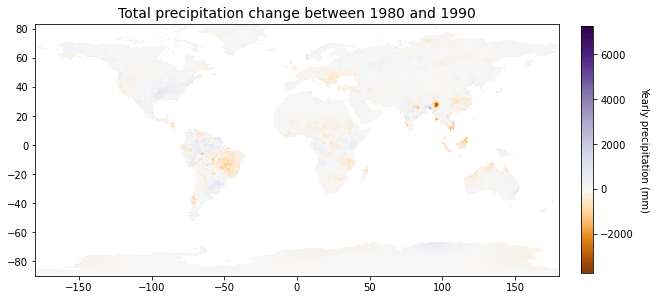

Compare: 1990 2000
Difference stats: -2258.2002 13.57 2061.2002


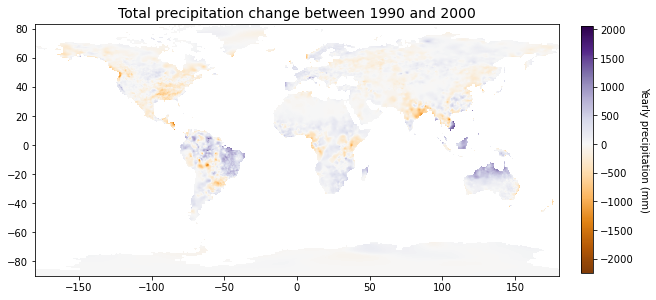

Compare: 2000 2010
Difference stats: -2140.5999 -2.72 3748.2998


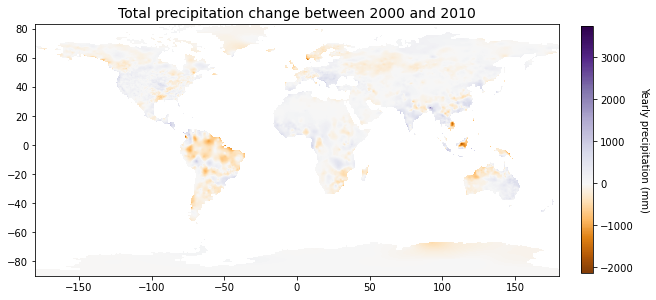

In [6]:
years = [1980,1990,2000,2010]
# loop over pairs of years
for i in range(len(years)-1):
    year1 = years[i]
    year2 = years[i+1]
    print("Compare:", year1, year2)
    # load the two rasters to compare
    rast1 = rasterio.open('data/global_precip_raster-{}.asc'.format(year1), mask=True)
    rast2 = rasterio.open('data/global_precip_raster-{}.asc'.format(year2), mask=True)
    vals1 = rast1.read(1, masked=True)
    vals2 = rast2.read(1, masked=True)
    # calculate difference
    vals_diff = vals2-vals1
    print("Difference stats:", vals_diff.min(), round(vals_diff.mean(),2), vals_diff.max())
    # plot difference
    plot_raster(rast1, vals_diff, 'Total precipitation change between {} and {}'.format(year1,year2), 
            'Yearly precipitation (mm)', 'PuOr', width=10, height=10, diverge_zero=True)
    
# note that 'PuOr' is suitable to intuitively represent wetter as blue and drier as red.

### c. 
What is the total precipitation in each country in 2015? Using world boundaries, use zonal statistics to answer this question. For each country, calculate the min, max, mean, median, and total precipitation. Save the results in a CSV table with a row for each country and a column for each descriptive statistic. Note that the precipitation data is very coarse and the results might exhibit pretty large errors for small countries. Repeat the analysis for 1980: You should make very minimal changes to the code.

In [7]:
# download world boundaries
url = 'https://github.com/andrea-ballatore/open-geo-data-education/raw/main/datasets/world_country_boundaries_2018/natural_earth_world_boundaries_50m_2018.geojson?raw=true'
file_name = 'data/natural_earth_world_boundaries_50m_2018.geojson'
urllib.request.urlretrieve(url, file_name)

('data/natural_earth_world_boundaries_50m_2018.geojson',
 <http.client.HTTPMessage at 0x170815490>)

235


<AxesSubplot:>

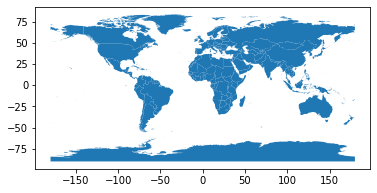

In [8]:
# load world boundaries
countries_df = geopandas.read_file('data/natural_earth_world_boundaries_50m_2018.geojson')
# remove unrecognised countries
countries_df = countries_df[countries_df.iso_a3 != '-99']
print(len(countries_df))
countries_df.plot()

In [9]:
from rasterstats import zonal_stats, gen_zonal_stats

for year in [1980, 2015]:
    print("\nCalculating zonal stats between world country borders and precipitation in {}...".format(year))
    # load precipitation raster
    rast_file = 'data/global_precip_raster-{}.asc'.format(year)
    # generate output file path
    output_file = 'tmp/precipitation_country_stats_{}.csv'.format(year)
    # calculate zonal stats.
    # select only relevant columns from countries_df
    zon_stats = zonal_stats(countries_df[['iso_a3','name','geometry']], rast_file, 
                            stats="count min median mean max sum", geojson_out=True)
    # generate a data frame from the zonal_stats results (list of dictionaries)
    stats_gdf = geopandas.GeoDataFrame.from_features(zon_stats)
    # convert from geodataframe to dataframe, as we do not need the geometries
    stats_df = pd.DataFrame(stats_gdf.drop(columns='geometry'))    
    # remove countries for which we have no observations
    stats_df = stats_df[stats_df['count'] > 0]
    stats_df = stats_df.sort_values('sum')
    # print statistics
    print(stats_df.describe())
    # save results in file
    stats_df.to_csv(output_file, index=False)
    print("Results in",output_file)


Calculating zonal stats between world country borders and precipitation in 1980...
               min          max         mean         count           sum  \
count   184.000000   184.000000   184.000000    184.000000  1.840000e+02   
mean    584.955435  2141.630439  1098.580447    462.021739  2.441909e+05   
std     609.162886  1570.111066   793.984143   2071.649938  6.773295e+05   
min       0.000000    65.300003    18.021053      1.000000  2.209000e+02   
25%      92.725000   967.824982   520.113208     13.000000  1.358843e+04   
50%     476.000000  1799.950012   911.571913     62.000000  4.707215e+04   
75%     811.799988  2919.250000  1579.894516    229.750000  1.584133e+05   
max    3355.699951  8657.000000  3709.935547  23984.000000  4.941679e+06   

            median  
count   184.000000  
mean   1052.174457  
std     782.844928  
min       4.800000  
25%     467.162506  
50%     841.800018  
75%    1472.725006  
max    3429.199951  
Results in tmp/precipitation_country_stats

### d. 

Using `.rank()`, generate rankings for countries in terms of their precipitation (rank 1 corresponding to the wettest country). Show the top 10 driest and wettest countries in the world in 1980 and 2015. Can you notice many changes?

In [10]:
# we define the "wet rank" based on the mean precipitation.
years = [1980,2015]

# merge stats for each year
wet_rank_df = countries_df[['iso_a3','name']]

for year in years:
    input_stats_file = 'tmp/precipitation_country_stats_'+str(year)+'.csv'
    print("ranking",input_stats_file)
    # load file and generate rankings
    stats_df = pd.read_csv(input_stats_file)
    # generate rankings
    rank_field = 'wet_rank_'+str(year)
    stats_df[rank_field] = stats_df['mean'].rank(ascending=False)
    # merge ranking with final results
    wet_rank_df = wet_rank_df.merge(stats_df[['iso_a3',rank_field]], 
                                    on='iso_a3')

# sort and save results
wet_rank_df['wet_rank_change'] = wet_rank_df['wet_rank_1980']-wet_rank_df['wet_rank_2015']
wet_rank_df = wet_rank_df.sort_values('wet_rank_2015')
wet_rank_df.to_csv('tmp/precipitation_country_stats.csv', index=False)

ranking tmp/precipitation_country_stats_1980.csv
ranking tmp/precipitation_country_stats_2015.csv


In [11]:
# wettest countries in 2015
wet_rank_df.head(10)

,iso_a3,name,wet_rank_1980,wet_rank_2015,wet_rank_change
148,COM,Comoros,4.0,1.0,3.0
40,SLB,Solomon Is.,3.0,2.0,1.0
145,CRI,Costa Rica,1.0,3.0,-2.0
162,BRN,Brunei,2.0,4.0,-2.0
167,BTN,Bhutan,12.0,5.0,7.0
81,MYS,Malaysia,6.0,6.0,0.0
58,PNG,Papua New Guinea,8.0,7.0,1.0
5,VUT,Vanuatu,74.0,8.0,66.0
47,WSM,Samoa,5.0,9.0,-4.0
27,TWN,Taiwan,36.0,10.0,26.0


In [12]:
# driest countries in 2015
wet_rank_df.tail(10)

,iso_a3,name,wet_rank_1980,wet_rank_2015,wet_rank_change
94,KWT,Kuwait,171.0,175.0,-4.0
2,YEM,Yemen,175.0,176.0,-1.0
137,DJI,Djibouti,179.0,177.0,2.0
46,SAU,Saudi Arabia,176.0,178.0,-2.0
180,DZA,Algeria,177.0,179.0,-2.0
73,ESH,W. Sahara,183.0,180.0,3.0
15,ARE,United Arab Emirates,174.0,181.0,-7.0
61,OMN,Oman,181.0,182.0,-1.0
87,LBY,Libya,182.0,183.0,-1.0
134,EGY,Egypt,184.0,184.0,0.0


<AxesSubplot:>

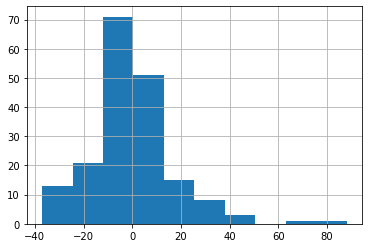

In [13]:
# observe countries with extreme changes in the ranking
wet_rank_df['wet_rank_change'].hist()

In [14]:
# show countries that exhibit extreme changes in the ranking, 
# from the country that has become more wet to the least wet. 
wet_rank_df = wet_rank_df.sort_values('wet_rank_change', ascending=False)
# We can check if values are a in range with .between(min, max).
# Note that ~ means "not" in pandas.
extreme_change_df = wet_rank_df[~wet_rank_df.wet_rank_change.between(-20, 20)]
extreme_change_df

,iso_a3,name,wet_rank_1980,wet_rank_2015,wet_rank_change
60,PAK,Pakistan,161.0,73.0,88.0
5,VUT,Vanuatu,74.0,8.0,66.0
182,AFG,Afghanistan,156.0,109.0,47.0
120,GMB,Gambia,129.0,85.0,44.0
177,ARM,Armenia,149.0,111.0,38.0
57,PRY,Paraguay,81.0,48.0,33.0
35,LKA,Sri Lanka,47.0,14.0,33.0
62,NOR,Norway,116.0,83.0,33.0
45,SEN,Senegal,135.0,103.0,32.0
95,KEN,Kenya,140.0,112.0,28.0


### e. 
Using `urllib.request.urlretrieve`, download this dataset containing global airports. Load it into a geo data frame with `geopandas` and print how many rows it contains. Select a few attributes from it, including the airport name, airport IATA code, country code, elevation, and type.

In [15]:
airports_url = 'https://raw.githubusercontent.com/andrea-ballatore/open-geo-data-education/main/datasets/airports/airports_2020.geojson?raw=true'
local_file_name = 'data/airports_2020.geojson'
print(local_file_name)
urllib.request.urlretrieve(airports_url, local_file_name)

data/airports_2020.geojson


('data/airports_2020.geojson', <http.client.HTTPMessage at 0x1709a7b20>)

In [12]:
airports_all_df = geopandas.read_file('data/airports_2020.geojson')
print('n airports =',len(airports_all_df))
print(airports_all_df.columns)
airports_all_df.sample(5)

n airports = 3187
Index(['FID', 'id', 'ident', 'type', 'name', 'latitude_d', 'longitude_',
       'elevation_', 'continent', 'iso_countr', 'iso_region', 'municipali',
       'scheduled_', 'gps_code', 'iata_code', 'local_code', 'home_link',
       'wikipedia_', 'keywords', 'id_1', 'airport_re', 'airport_id',
       'length_ft', 'width_ft', 'surface', 'lighted', 'closed', 'le_ident',
       'le_latitud', 'le_longitu', 'le_elevati', 'le_heading', 'le_displac',
       'he_ident', 'he_latitud', 'he_longitu', 'he_elevati', 'he_heading',
       'he_displac', 'ObjectID', 'type_1', 'descriptio', 'frequency_',
       'geometry'],
      dtype='object')


,FID,id,ident,type,name,latitude_d,longitude_,elevation_,continent,iso_countr,...,he_latitud,he_longitu,he_elevati,he_heading,he_displac,ObjectID,type_1,descriptio,frequency_,geometry
1915,1916,5321.0,OYTZ,medium_airport,Ta'izz International Airport,13.686000,44.139099,4838.0,AS,YE,...,13.69970,44.1409,4838,188,None,29680.0,GND,TAIZ GND,121.600,POINT Z (44.13910 13.68600 0.00000)
293,294,2041.0,CZTM,medium_airport,Shamattawa Airport,55.865601,-92.081398,289.0,NA,CA,...,NaN,NaN,None,None,None,13905.0,None,None,NaN,POINT Z (-92.08140 55.86560 0.00000)
7,8,59.0,AYHK,medium_airport,Kimbe Airport,-5.462170,150.404999,66.0,OC,PG,...,-5.46704,150.4100,66,313,None,11331.0,FSS,NADZAB CNTR,127.100,POINT Z (150.40500 -5.46217 0.00000)
965,966,3497.0,KDTW,large_airport,Detroit Metropolitan Wayne County Airport,42.212399,-83.353401,645.0,NA,US,...,42.22830,-83.3361,632,209,None,20483.0,APP,APP,118.575,POINT Z (-83.35340 42.21240 0.00000)
640,641,2917.0,FMNH,medium_airport,Antsirabato Airport,-14.999400,50.320202,20.0,AF,MG,...,-15.00460,50.3219,16,343,None,16373.0,A/G,A/G VOICE RDO,548.400,POINT Z (50.32020 -14.99940 0.00000)


In [13]:
airports_df = airports_all_df[['id','iata_code','name','type','iso_countr','elevation_','geometry']]
# rename elevation to show it is in feet
airports_df = airports_df.rename(columns={"elevation_": "elevation_ft"})
# show sample
airports_df.sample(5)

,id,iata_code,name,type,iso_countr,elevation_ft,geometry
1771,5088.0,DWD,King Salman Abdulaziz Airport,medium_airport,SA,3026.0,POINT Z (44.12120 24.44990 0.00000)
2722,31790.0,KXK,Komsomolsk-on-Amur Airport,medium_airport,RU,92.0,POINT Z (136.93401 50.40900 0.00000)
411,2398.0,MAN,Manchester Airport,large_airport,GB,257.0,POINT Z (-2.27495 53.35370 0.00000)
2319,6132.0,EOH,Enrique Olaya Herrera Airport,medium_airport,CO,4949.0,POINT Z (-75.59058 6.22055 0.00000)
2957,27044.0,ABX,Albury Airport,medium_airport,AU,539.0,POINT Z (146.95799 -36.06780 0.00000)


### f. 
Analyse the density of airports around in the world. First, using a 2D histogram with different numbers of bins (from 20 to 100). Do the analysis for all airports and just for large airports (`type=='large_airport'`).

bin_n 40


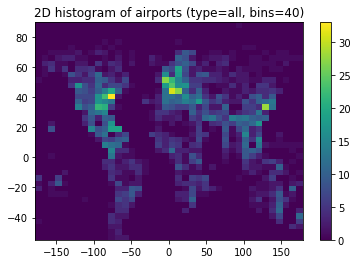

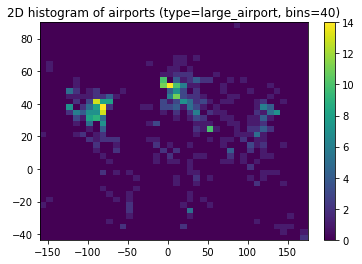

bin_n 80


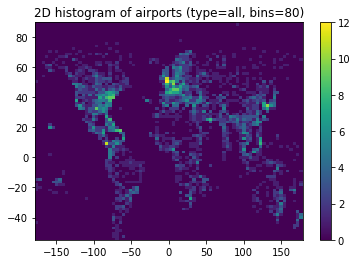

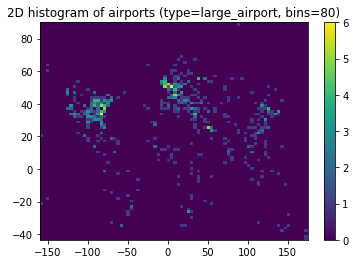

bin_n 120


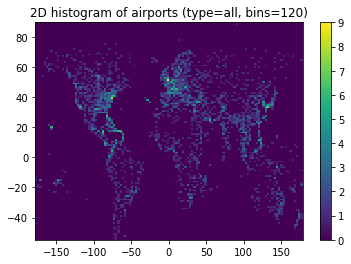

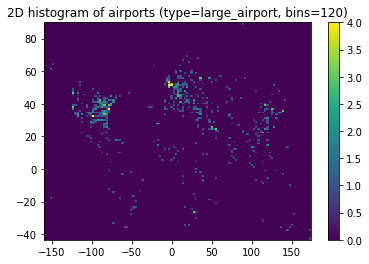

bin_n 160


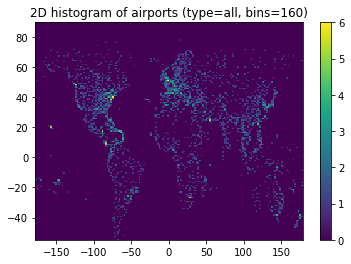

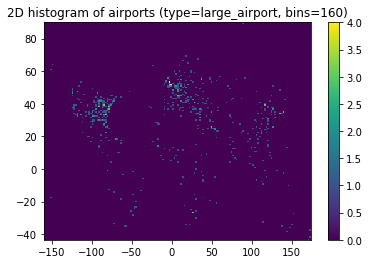

bin_n 200


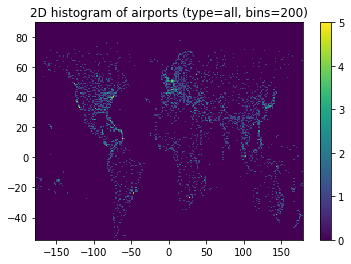

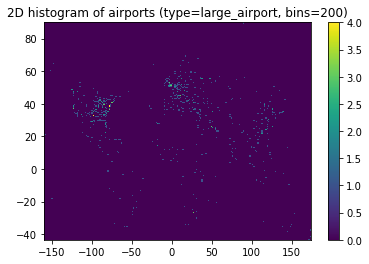

In [18]:
# vary the number of bins:
for bin_n in range(40,201,40):
    print("bin_n",bin_n)
    
    # vary the types
    for atype in ['all','large_airport']:
        df = airports_df
        if atype != 'all':
            df = airports_df[airports_df['type'] == atype]
        assert len(df) > 0
        # the airports we need are in df
        h = plt.hist2d(df.geometry.x, df.geometry.y, bins=bin_n, density=False)
        plt.colorbar(h[3])
        plt.title("2D histogram of airports (type={}, bins={})".format(atype, bin_n))
        plt.show()

### g. 
Generate KDEs of airports for Britain and the US varying the bandwidth to three different values that capture the airport distribution in an appropriate way. Where are the densest areas in the world? Divide the analysis between all aiports and just large airports, minimising the code repetition.

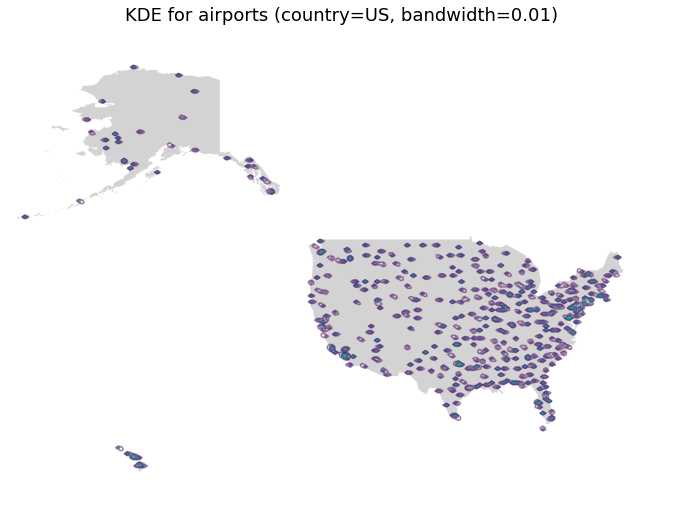

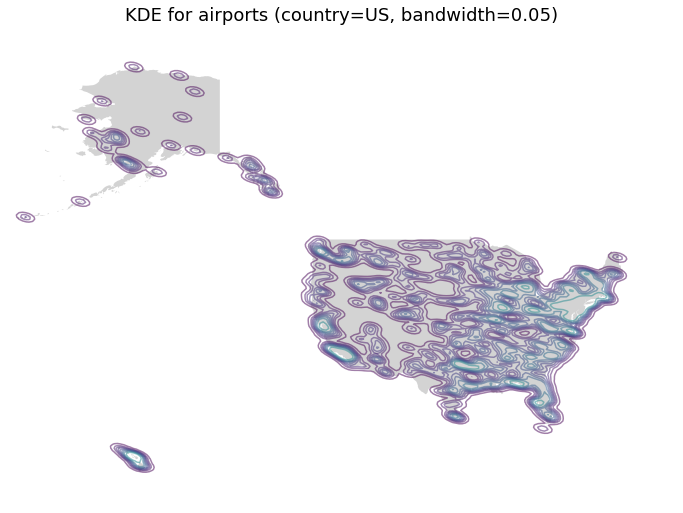

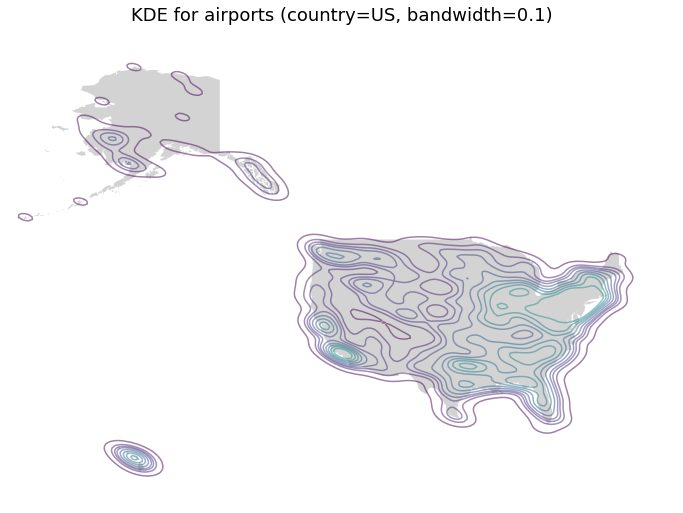

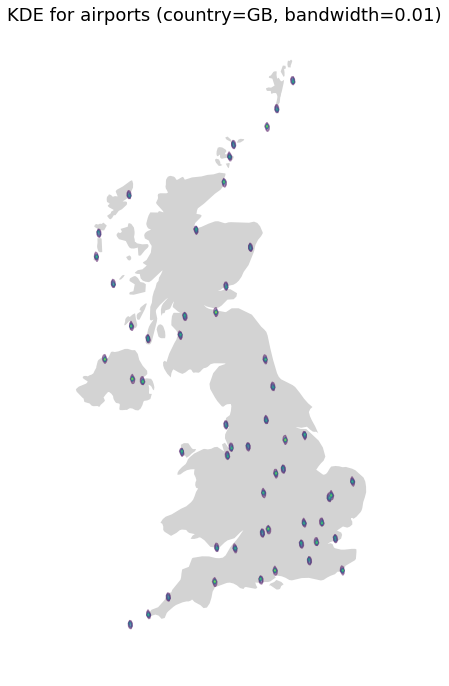

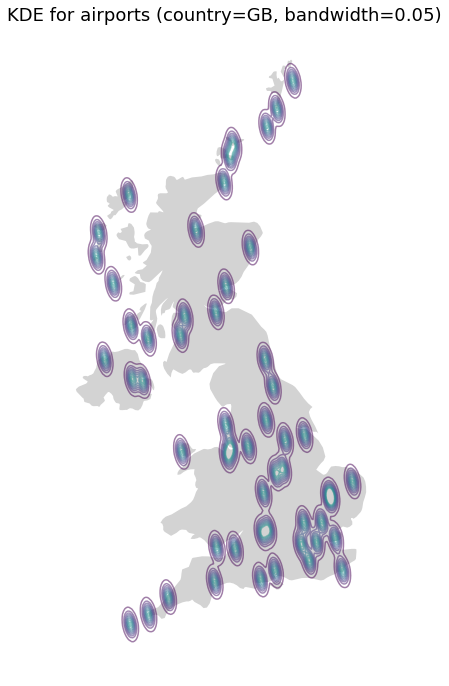

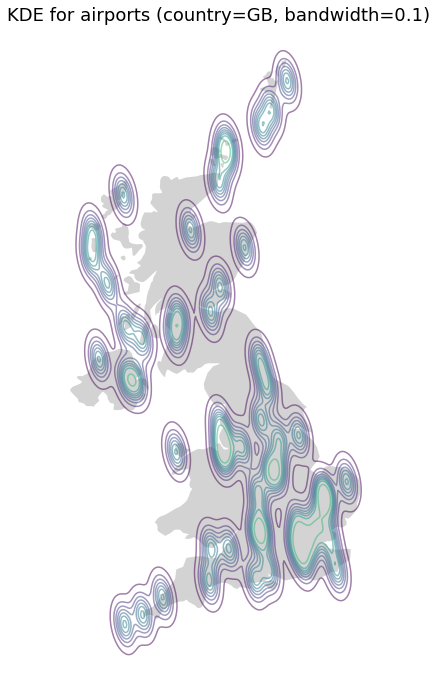

In [19]:
for country in ['US','GB']:
    # select airports in adf
    adf = airports_df[airports_df['iso_countr']==country]
    cdf = countries_df[countries_df['iso_a2']==country]
    if country == 'GB':
        # fix to remove a RAF airport in Cyprus
        adf = adf[adf['iata_code']!='AKT']
    assert len(cdf) > 0
    assert len(adf) > 0
    # vary bandwidth
    for bandwidth in [.01,.05,.1]:
        title = 'KDE for airports (country={}, bandwidth={})'.format(country, bandwidth)
        ax = geoplot.kdeplot(adf, shade=False, bw=bandwidth, figsize=(12, 12), alpha=.5)
        # add shorelines
        cdf.plot(ax=ax, color='lightgray', edgecolor="none", linewidth=.5)
        # add title
        plt.title(title, fontsize=18)
        # show figure
        plt.show()

End of notebook